In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
import os
from pathlib import Path
import numpy as np
from astropy.time import Time
from astropy.io import fits
import astropy.units as u

In [10]:
FILE_FRAMES = {'tcorr': '{}_pp_e2dsff_tcorr_AB.fits',
               'recon': '{}_pp_e2dsff_recon_AB.fits',
               'pclean': '{}_pp_tellu_pclean_AB.fits'}

In [31]:
base_dir = Path.home() / Path('/home/adb/projects/def-dlafre/adb/')


if base_dir is None:
    try:
        base_dir = os.environ['SCRATCH']
    except KeyError:
        base_dir = Path.home()

obs_dir = base_dir / Path('Observations/SPIRou/v07275/WASP33/')

In [33]:
obs_jd = []
filenames = []
for entry in obs_dir.glob('*e2dsff_AB.fits'):
    valid_file = True
    hdu = fits.open(entry)
    # Check if other files needed exist
    obs_id = hdu[0].header['filename']
    for reduction_type, f_format in FILE_FRAMES.items():
        other_file = f_format.format(obs_id)
        other_file = obs_dir / Path(other_file)
        if not other_file.is_file():
            print(f'{reduction_type} not found with filename: {other_file.name}')
            valid_file = False
    
    if valid_file:
        obs_jd.append(hdu[0].header['BJD'])
        filenames.append(entry.name)

tcorr not found with filename: 2689390o_pp_e2dsff_tcorr_AB.fits
recon not found with filename: 2689390o_pp_e2dsff_recon_AB.fits
pclean not found with filename: 2689390o_pp_tellu_pclean_AB.fits
tcorr not found with filename: 2689388o_pp_e2dsff_tcorr_AB.fits
recon not found with filename: 2689388o_pp_e2dsff_recon_AB.fits
pclean not found with filename: 2689388o_pp_tellu_pclean_AB.fits
tcorr not found with filename: 2689392o_pp_e2dsff_tcorr_AB.fits
recon not found with filename: 2689392o_pp_e2dsff_recon_AB.fits
pclean not found with filename: 2689392o_pp_tellu_pclean_AB.fits
tcorr not found with filename: 2689389o_pp_e2dsff_tcorr_AB.fits
recon not found with filename: 2689389o_pp_e2dsff_recon_AB.fits
pclean not found with filename: 2689389o_pp_tellu_pclean_AB.fits
tcorr not found with filename: 2689391o_pp_e2dsff_tcorr_AB.fits
recon not found with filename: 2689391o_pp_e2dsff_recon_AB.fits
pclean not found with filename: 2689391o_pp_tellu_pclean_AB.fits


In [34]:
idx_sort = np.argsort(obs_jd)
filenames = np.array(filenames)
filenames = filenames[idx_sort]
# filenames = [filenames[idx] for idx in idx_sort]

In [35]:
obs_jd = obs_jd * u.d
obs_jd = obs_jd[idx_sort]

In [36]:
# t_start = Time(np.array(obs.headers.get_all('BJD')[0], dtype='float'), format='jd').jd.squeeze() * u.d

In [37]:
from astropy.stats import sigma_clip

In [38]:
from scipy.signal import find_peaks

In [39]:
def find_sequence_gaps(time_stamps, n_iter=10):
    """Automatically find the index of new sequence.
    This is done by finding the delta t jumps"""

    idx_steps, _ = find_peaks(np.diff(time_stamps), height=1)
    
    return np.array(idx_steps)



In [40]:
def split_gaps(time_stamps):
    
    if np.any(np.diff(time_stamps) < 0):
        raise ValueError('`time_stamps` must be sorted.')

    idx_steps = find_sequence_gaps(time_stamps)
    idx_start = [None] + list(idx_steps + 1)
    idx_end = list(idx_steps + 1) + [None]
    indices = np.arange(len(time_stamps))

    transit_tags = []
    for i_start, i_end in zip(idx_start, idx_end):
        slice_sequence = slice(i_start, i_end)
        tr_tag = indices[slice_sequence]
        if tr_tag.any():
            transit_tags.append(indices[slice_sequence])
        
    return transit_tags

In [41]:
transit_tags = split_gaps(obs_jd)

In [42]:
%matplotlib notebook

<IPython.core.display.Javascript object>


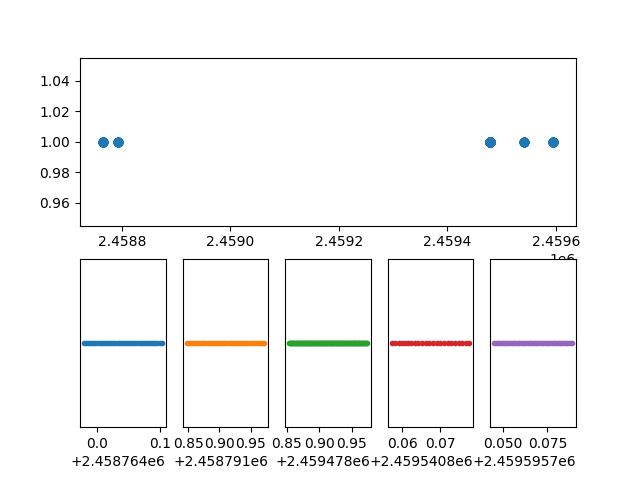

/tmp/ipykernel_2149977/4206684632.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_tag = plt.subplot2grid((2, n_tags), (1, idx_tag))


In [43]:
n_tags = len(transit_tags)

fig = plt.figure()
ax_all = plt.subplot2grid((2, 1), (0, 0))
# ax_all = plt.subplot(2, 4, (1, 1))
# ax_all = plt.subplot(2, 1, (1, 1))
ax_all.plot(obs_jd, np.ones_like(obs_jd), 'o')

ax_all = plt.subplot2grid((2, 4), (1, 0))

for idx_tag, tr_tag in enumerate(transit_tags):
    ax_tag = plt.subplot2grid((2, n_tags), (1, idx_tag))
    ax_all.plot(obs_jd[tr_tag], np.ones_like(obs_jd[tr_tag]), '.')
    color = ax_all.get_lines()[-1].get_color()
    ax_tag.plot(obs_jd[tr_tag], np.ones_like(obs_jd[tr_tag]), '.', color=color)
    ax_tag.set_yticks([])

In [44]:
for tr_tag in transit_tags:
    hdu = fits.open(obs_dir / filenames[tr_tag[0]])
    print(filenames[tr_tag[0]], hdu[0].header['PI_NAME'], hdu[0].header['DATE'])
    test = Time(hdu[0].header['DATE'])

2446828o_pp_e2dsff_AB.fits Antoine Darveau-Bernier 2019-10-07T11:24:06
2454981o_pp_e2dsff_AB.fits Antoine Darveau-Bernier 2019-11-04T08:13:37
2637647o_pp_e2dsff_AB.fits Louis-Philippe Coulombe 2021-09-21T08:23:55
2689365o_pp_e2dsff_AB.fits Louis-Philippe Coulombe 2021-11-22T08:26:16
2697068o_pp_e2dsff_AB.fits Louis-Philippe Coulombe 2022-01-16T05:49:27


## Create lists of files to be read

In [45]:
for idx_tr, tr_tag in enumerate(transit_tags):
    filenames_tr = filenames[tr_tag]
    hdu = fits.open(obs_dir / filenames_tr[0])
    date = Time(hdu[0].header['DATE'])
    date = date.datetime.date()
    name_list_files = Path(f'list_e2ds_visit_{date}')
    print(f'Writing to {name_list_files}')
    with open(obs_dir / name_list_files, 'w') as f:
        output = '\n'.join(filenames_tr)
        f.write(output + '\n')
    
    file_lists = {key: [] for key in FILE_FRAMES}
    for tr_file in filenames_tr:
        hdu = fits.open(obs_dir / tr_file)
        obs_id = hdu[0].header['filename']
        for reduction_type, f_format in FILE_FRAMES.items():
            other_file = f_format.format(obs_id)
            file_lists[reduction_type].append(other_file)
            
    for reduc_type, reduc_flist in file_lists.items():
        name_list_files = Path(f'list_{reduc_type}_visit_{date}')
        print(f'Writing to {name_list_files}')
        with open(obs_dir / name_list_files, 'w') as f:
            output = '\n'.join(reduc_flist)
            f.write(output + '\n')

Writing to list_e2ds_visit_2019-10-07
Writing to list_tcorr_visit_2019-10-07
Writing to list_recon_visit_2019-10-07
Writing to list_pclean_visit_2019-10-07
Writing to list_e2ds_visit_2019-11-04
Writing to list_tcorr_visit_2019-11-04
Writing to list_recon_visit_2019-11-04
Writing to list_pclean_visit_2019-11-04
Writing to list_e2ds_visit_2021-09-21
Writing to list_tcorr_visit_2021-09-21
Writing to list_recon_visit_2021-09-21
Writing to list_pclean_visit_2021-09-21
Writing to list_e2ds_visit_2021-11-22
Writing to list_tcorr_visit_2021-11-22
Writing to list_recon_visit_2021-11-22
Writing to list_pclean_visit_2021-11-22
Writing to list_e2ds_visit_2022-01-16
Writing to list_tcorr_visit_2022-01-16
Writing to list_recon_visit_2022-01-16
Writing to list_pclean_visit_2022-01-16
